# Exercises

## Exercise 1: Image characteristics
---

**A.** Distiguishing pixels   

Fluctuations in the activitation of the neuron can be directly observed on the video or in a temporal trace plot of each pixel. Plotting the temporal trace will allow us to see the calcium transient dinamic, if a pixel belonging to a neuron is selected. 

* Select a set of *N* random pixels from the ROI and plot the temporal evolution of pixel value. If the random pixels are choosen from an active neuron, you will be able to see the calcium transcient dynamic. Try this a few time to appreciate the results.

**B.** Temporal statistics of pixel activation
 * For the selected pixels, plot the histogram of pixel value. What are the difference in different regions?, and how can that help to distinguish a pixel that belongs to aneuron from a background pixel?

* If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels? 

In [3]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import psutil
from pathlib import Path

# CaImAn funtions and objects
import caiman as cm
from caiman.motion_correction import MotionCorrect, high_pass_filter_space
from caiman.source_extraction.cnmf import params as params
from caiman.source_extraction import cnmf
from caiman.source_extraction.cnmf.cnmf import load_CNMF

import sys
import os
sys.path.append(os.path.abspath("code"))
from utils import download_data
import auxiliary_functions as aux

In [4]:
# load data
download_data('https://surfdrive.surf.nl/files/index.php/s/yQT6yv34jDu6csE')

# ROI data
input_tif_file_path = 'data/caiman_video_trial_0.tif' 

In [ ]:
# Part A: Temporal Evolution of Pixel Intensity
# load movie and compute mean imges with caiman functions
original_movie = cm.load(input_tif_file_path)
mean_image = cm.summary_images.mean_image(input_tif_file_path)

# correlation image

# for every pixel, it computes the correlation over time with its four (or more) nearest neighbours, and takes their mean. 
# The idea is that pixel belonging to the same cell will be active together, 
# while pixel pairs belonging to the noisy backgorund, or made of one 'neuron' pixel and one 'background' pixel 
# will not be correlated.

correlation_image,pnr_image = cm.summary_images.correlation_pnr(original_movie,swap_dim=False)

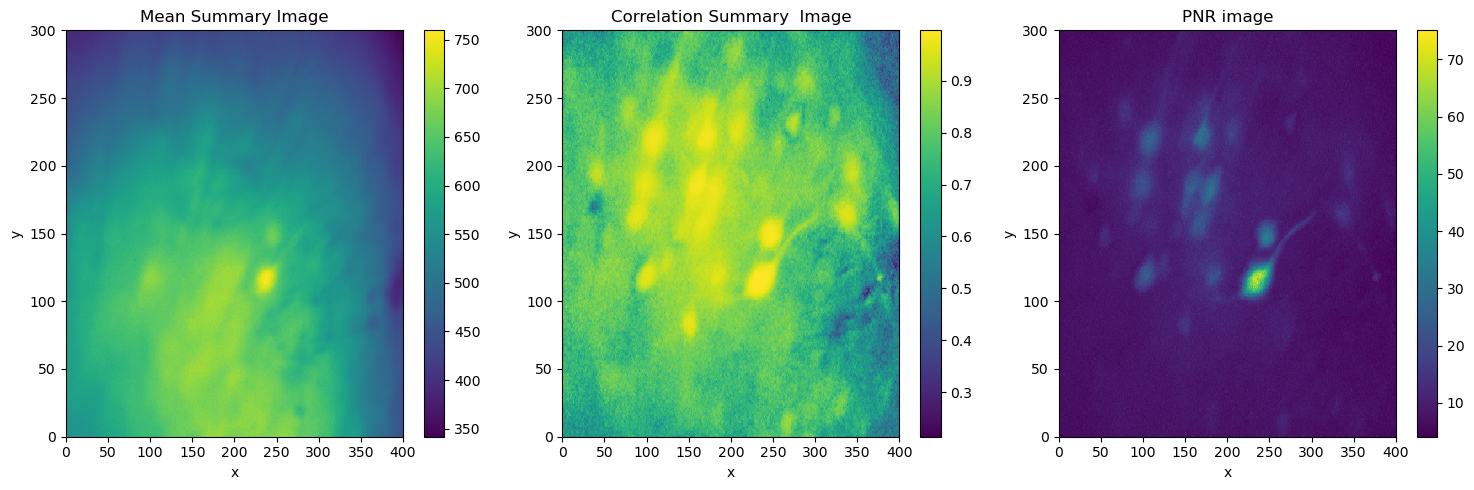

In [5]:
# Plot summary images
figure, axes = plt.subplots(1,3,figsize=(15,5))


axes[0].set_xlabel('x')
axes[0].set_ylabel('y')
axes[0].set_title('Mean Summary Image')

axes[1].set_xlabel('x')
axes[1].set_ylabel('y')
axes[1].set_title('Correlation Summary  Image')

axes[2].set_xlabel('x')
axes[2].set_ylabel('y')
axes[2].set_title('PNR image')

mesh0 = axes[0].pcolormesh(mean_image)
mesh1 = axes[1].pcolormesh(correlation_image)
mesh2 = axes[2].pcolormesh(pnr_image)

figure.colorbar(mesh0,ax=axes[0])
figure.colorbar(mesh1,ax=axes[1])
figure.colorbar(mesh2,ax=axes[2])


plt.tight_layout()

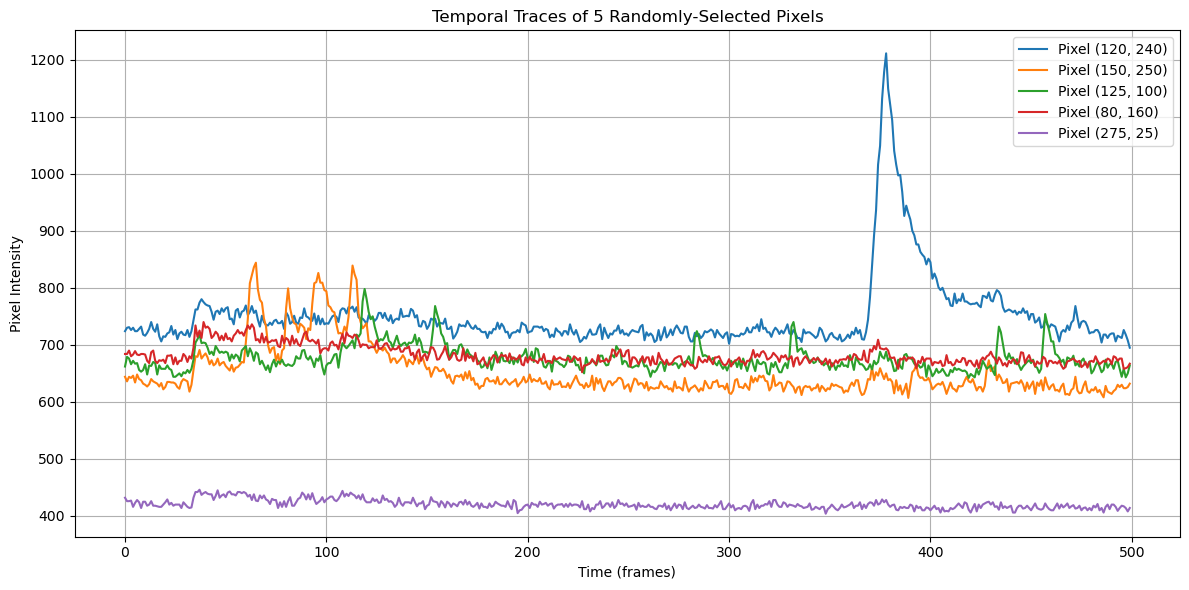

In [39]:
# selecting random pixels

# format: (y-coordinate, x-coordinate)
pixel_coords = [
    (120, 240), # looking at the mean summmary and PNR image, this one is likely an active neuron with a large magnitude
    (150, 250), # slightly less bold signal
    (125, 100),
    (80, 160),
    (275, 25)] # selecting pixel at periphery
    
# plotting temporal dynamics of selected pixels
plt.figure(figsize=(12, 6))
for y, x in pixel_coords:
    trace = original_movie[:, y, x].squeeze()
    plt.plot(trace, label=f'Pixel ({y}, {x})')
plt.xlabel('Time (frames)')
plt.ylabel('Pixel Intensity')
plt.title('Temporal Traces of 5 Randomly-Selected Pixels')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


**Report**

To start this exercise, I first extracted the summary images shown above. To look at the temporal evolution in signal intensity of random pixels, I then randomly selected coordinates and observed how the temporal trace plot changed. Following this, I then selected a few pixels guided by the summary images, in order to display differences between active neurons and background more explicitly. 


**Conclusion** 
When choosing random coordinates for the pixels, one can distinguish active neurons from non-active ones/background by changes in pixel activity. Specifically, the calcium transient dynamics are characterized by sharp increases and decreases. In the example above, the most obvious example is presented by the first pixel, with a large sharp rise at time point 375. The second pixel shows less strong, but more frequent calcium increases between t = 75 and 120. Lastly, Pixel 5 was selected from a non-active background area. 

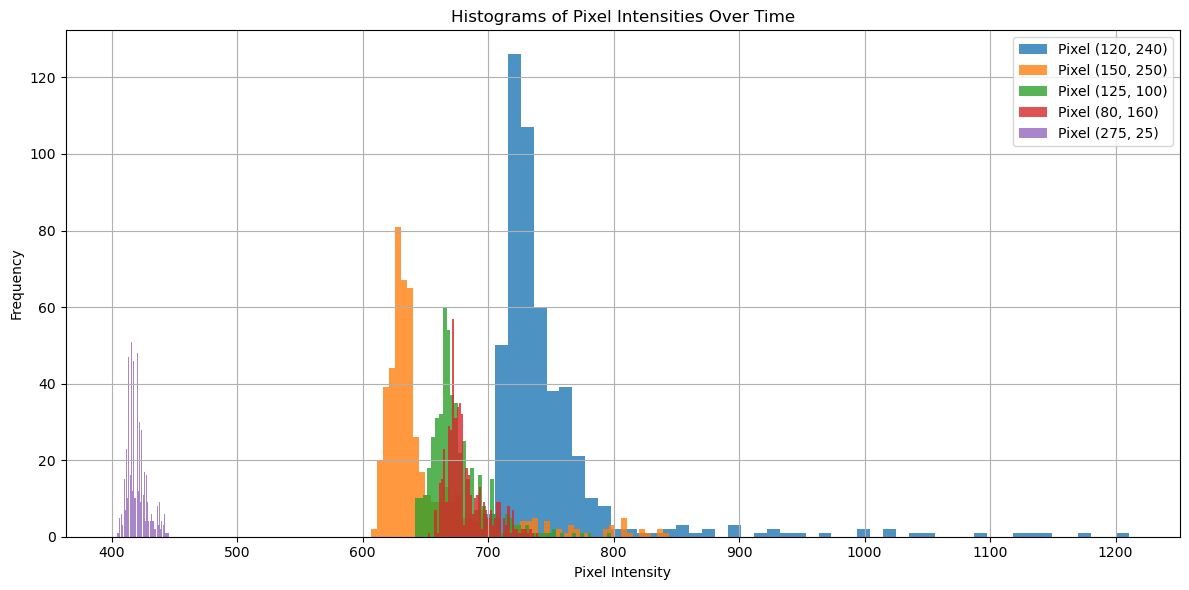

In [45]:
# Part B: Temporal statistics of pixel activation

plt.figure(figsize=(12, 6))
for y, x in pixel_coords: 
    trace = original_movie[:, y, x].squeeze()
    plt.hist(trace, bins=50, alpha=, label=f'Pixel ({y}, {x})')
plt.xlabel('Pixel Intensity')
plt.ylabel('Frequency') # i.e. how often intensity value occurs across time
plt.title('Histograms of Pixel Intensities Over Time')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

**Report**
Using the selected pixels from the previous exercise, I created a histogram of pixel intensity against frequency (i.e. how often intensity values occur across time). 


**Conclusions**

**What are the differences in different regions? How can that help to distinguish a pixel that belongs to a neuron from a background pixel?**

- Looking at the histogram, we can see that the first 4 pixels are higher in average intensity than the last pixel. As such, they more likely represent neuron pixels, while the last pixel is a background pixel, as indicates by the low central signal intensity. 
- Additionally, the spread of the neuron pixels' peaks is more broad, i.e. the pixels exhibit a wider range of signal intensities throughout time at different frequencies. They also tend to be more skewed, whereas the background pixel is more uniform in distribution.
- Based on this, we might be able to distinguish a neuron pixel from a background pixel. 

**If we can already see the calcium traces from individual pixels, why do we need to run source extraction to segment the neurons? Why, as a starter, would not be a good idea to work directly with the temporal traces of the pixels?**

- While the individual pixels can show some activity, working with them directly is not ideal because:
1) a neuron's signal is spread across multiple pixels instead of one, so only considering a single pixel likely misses the whole picture
2) neurons overlap in space, so a single pixel may contain signal from multiple neurons. In fact, the correlation image uses neighbouring pixels to calculate correlations and assumes that these are from the same cell, but this is not necessarily true. Therefore, to determine the true source of activity, sources need to be isolated. 
3) raw pixels are noisy. For the current anaylysis no motion correction was applied.

- Therefore, source extraction is important, as segments the image into distinct neurons (sources), ensuring accurary and improving interpretability.

## Exercise 2: motion correction parameters
---

One parameter that impacts motion correction performance is the size of the spatial filter that is applyed to the video.

* Use the following function from CaImAn and plot the result of different space filtering applyed to a single frame of the video:from caiman.motion_correction import high_pass_filter_space

* How will this filtering affect the measure of crispness?

* Acording to Pnevmatikakis et al, which other factors are relevant for pw-rigid motion correction?

- Explore the impact of different parameters in the output of motion correction algorithm by measuring crispness in the correlation image of the final outcome. Particularly measure the effect of different spatial filter size by applying motion correction algorithm multiple times and computing the crispness of the output video. 

- Display all crispness values for rigid and not rigid motion correction and plot them agains gSig_filters values.

- If possible, show the impact of the crispness value that comes from changing other relevant paraments.

*Note1: The is no need to save all the motion corrected movies, just save the cripsness values.*

*Note2: gSig_filters is an optional range of posible values, but if your computer gets to slow in the computation reduce the range.*


## Exercise 3: Source extraction parameters 
---

* For a fixed minimum correlation value (ie 0.6) select a range of possible PNR minimun values and study the impact of those in the final source extraction output.

* For a fixed value of PNR (ie 6) select a range of minimum correlation valur and study the impact of those in the final source extraction output.

* How do these paramenters affect the spatial sparcity of the output? Which set of parameter selection procedes the higher number of neurons? Is maximal number of neurons always better? Why?  

* Generate a plot of number of neurons vs PNR (or min corr value) to show how these parameters affect the source extracted signals.

* Are the temporal traces affected by these parameters?

* For different PNR and minimum correlation value plot the correlation image and the selected cells.